In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, models
from torchvision.datasets import EMNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 5070 Laptop GPU


In [4]:
# Data processing

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.RandomRotation((-90, -90)),  # Rotate -90 degrees
    transforms.RandomHorizontalFlip(p=1.0),  # Flip horizontally
    transforms.Resize((224, 224)),  # Resize to 224 x 224
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [5]:
# Load train dataset
full_train_dataset = EMNIST(
    root='./data', 
    split='byclass', 
    train=True, 
    download=True, 
    transform=transform
)

image, label = full_train_dataset[0]
print(f"Image size: {image.shape}")
print(f"Dataset length: {len(full_train_dataset)}")

# Split into train and validation
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size]
)
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Load test dataset
test_dataset = EMNIST(
    root='./data', 
    split='byclass', 
    train=False, 
    download=True, 
    transform=transform
)
print(f"Test dataset size: {len(test_dataset)}")

Image size: torch.Size([3, 224, 224])
Dataset length: 697932
Training dataset size: 628138
Validation dataset size: 69794
Test dataset size: 116323


In [6]:
# Data loaders
batch_size = 256  # Increased from 64 for better GPU utilization

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,  # Increased from 2
    pin_memory=True  # Faster data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test
    num_workers=4,
    pin_memory=True
)

In [7]:
# Load ResNet-18 and modify the output layer

def get_resnet18_model(num_classes=62):
    model = models.resnet18(pretrained=True)

    # Replace final FC layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model

model = get_resnet18_model(num_classes=62)
model = model.to(device)

/home/filthys/miniforge3/envs/ml_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/filthys/miniforge3/envs/ml_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_trainable_params_millions(model):
    return count_trainable_params(model) / 1e6

In [9]:
def freeze_backbone(model):
    """Freeze all layers except final FC layer"""
    for name, param in model.named_parameters():
        if 'fc' not in name:
            param.requires_grad = False
    print(f"Frozen backbone. Trainable params: {count_trainable_params_millions(model):.2f}M")

def unfreeze_last_block(model):
    """Unfreeze layer4 and FC layer"""
    for name, param in model.named_parameters():
        if 'layer4' in name or 'fc' in name:
            param.requires_grad = True
    print(f"Unfroze layer4. Trainable params: {count_trainable_params_millions(model):.2f}M")

def unfreeze_all(model):
    """Unfreeze all layers"""
    for param in model.parameters():
        param.requires_grad = True
    print(f"Unfroze all params. Trainable params: {count_trainable_params_millions(model):.2f}M")

In [10]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, use_amp=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Create GradScaler for AMP if enabled
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        if use_amp:
            # Use autocast for mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Scale loss and backprop
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Normal training without AMP
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [11]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        return epoch_loss, epoch_acc

In [12]:
def evaluate_full_metrics(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        conf_matrix = confusion_matrix(all_labels, all_preds)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': conf_matrix,
            'predictions': all_preds,
            'labels': all_labels
        }

In [13]:
def train_regime(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        num_epochs,
        device,
        regime_name="",
        use_amp=False
):
    print(f"\n{'='*70}")
    print(f"Training Regime: {regime_name}")
    if use_amp:
        print(f"Mixed Precision (AMP): Enabled")
    print(f"{'='*70}")

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    start_time = time.time()

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            device,
            use_amp=use_amp
        )
        val_loss, val_acc = validate(
            model,
            val_loader,
            criterion,
            device
        )

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if scheduler:
            scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{regime_name}_best_model.pth')

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")

    return history, training_time

In [14]:
# Training Regime 1: Linear Probe
print(f"\n{'='*70}")
print("REGIME 1: LINEAR PROBE")
print(f"{'='*70}")

model = get_resnet18_model().to(device)
freeze_backbone(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=5, 
    gamma=0.1
)

trainable_params_regime1 = count_trainable_params_millions(model)

history_regime1, time_regime1 = train_regime(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=10,
    device=device,
    regime_name="linear_probe",
    use_amp=torch.cuda.is_available()  # Enable AMP if CUDA available
)


REGIME 1: LINEAR PROBE
Frozen backbone. Trainable params: 0.03M

Training Regime: linear_probe
Mixed Precision (AMP): Enabled


/tmp/ipykernel_46379/66939090.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
/tmp/ipykernel_46379/66939090.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/10] Train Loss: 0.9050, Train Acc: 74.89% | Val Loss: 0.7084, Val Acc: 78.54%
Epoch [2/10] Train Loss: 0.6745, Train Acc: 79.31% | Val Loss: 0.6590, Val Acc: 79.61%
Epoch [3/10] Train Loss: 0.6394, Train Acc: 80.05% | Val Loss: 0.6484, Val Acc: 79.71%
Epoch [4/10] Train Loss: 0.6235, Train Acc: 80.44% | Val Loss: 0.6345, Val Acc: 79.90%
Epoch [5/10] Train Loss: 0.6134, Train Acc: 80.69% | Val Loss: 0.6178, Val Acc: 80.41%
Epoch [6/10] Train Loss: 0.5939, Train Acc: 81.33% | Val Loss: 0.6086, Val Acc: 80.89%
Epoch [7/10] Train Loss: 0.5929, Train Acc: 81.41% | Val Loss: 0.6075, Val Acc: 80.91%
Epoch [8/10] Train Loss: 0.5922, Train Acc: 81.43% | Val Loss: 0.6060, Val Acc: 80.93%
Epoch [9/10] Train Loss: 0.5916, Train Acc: 81.44% | Val Loss: 0.6063, Val Acc: 80.91%
Epoch [10/10] Train Loss: 0.5910, Train Acc: 81.47% | Val Loss: 0.6052, Val Acc: 80.89%

Training completed in 76.47 minutes
Best validation accuracy: 80.93%


In [15]:
# Training Regime 2: Partial Unfreeze (Layer4 + FC)
print(f"\n{'='*70}")
print("REGIME 2: PARTIAL UNFREEZE (LAYER4 + FC)")
print(f"{'='*70}")

# Load best model from Regime 1
model.load_state_dict(torch.load('linear_probe_best_model.pth'))
unfreeze_last_block(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)  # Lower LR
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

trainable_params_regime2 = count_trainable_params_millions(model)

history_regime2, time_regime2 = train_regime(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler,
    num_epochs=15, 
    device=device, 
    regime_name="partial_unfreeze",
    use_amp=torch.cuda.is_available()  # Enable AMP if CUDA available
)


REGIME 2: PARTIAL UNFREEZE (LAYER4 + FC)
Unfroze layer4. Trainable params: 8.43M

Training Regime: partial_unfreeze
Mixed Precision (AMP): Enabled


/tmp/ipykernel_46379/66939090.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
/tmp/ipykernel_46379/66939090.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/15] Train Loss: 0.4272, Train Acc: 85.15% | Val Loss: 0.3950, Val Acc: 85.89%
Epoch [2/15] Train Loss: 0.3645, Train Acc: 86.79% | Val Loss: 0.3768, Val Acc: 86.42%
Epoch [3/15] Train Loss: 0.3417, Train Acc: 87.43% | Val Loss: 0.3664, Val Acc: 86.61%
Epoch [4/15] Train Loss: 0.3262, Train Acc: 87.89% | Val Loss: 0.3598, Val Acc: 86.84%
Epoch [5/15] Train Loss: 0.3142, Train Acc: 88.27% | Val Loss: 0.3563, Val Acc: 86.95%
Epoch [6/15] Train Loss: 0.3044, Train Acc: 88.58% | Val Loss: 0.3544, Val Acc: 86.92%
Epoch [7/15] Train Loss: 0.2959, Train Acc: 88.89% | Val Loss: 0.3534, Val Acc: 87.06%
Epoch [8/15] Train Loss: 0.2888, Train Acc: 89.12% | Val Loss: 0.3532, Val Acc: 87.05%
Epoch [9/15] Train Loss: 0.2827, Train Acc: 89.34% | Val Loss: 0.3516, Val Acc: 87.07%
Epoch [10/15] Train Loss: 0.2775, Train Acc: 89.54% | Val Loss: 0.3526, Val Acc: 87.02%
Epoch [11/15] Train Loss: 0.2734, Train Acc: 89.71% | Val Loss: 0.3516, Val Acc: 87.10%
Epoch [12/15] Train Loss: 0.2703, Train A

In [16]:
# Evaluate on Test Set
model.load_state_dict(torch.load('partial_unfreeze_best_model.pth'))

print(f"\n{'='*70}")
print("EVALUATING ON TEST SET")
print(f"{'='*70}")

test_metrics = evaluate_full_metrics(model, test_loader, device)
print(f"Test Accuracy: {test_metrics['accuracy']*100:.2f}%")
print(f"Test Precision (macro): {test_metrics['precision']:.4f}")
print(f"Test Recall (macro): {test_metrics['recall']:.4f}")
print(f"Test F1-Score (macro): {test_metrics['f1']:.4f}")


EVALUATING ON TEST SET
Test Accuracy: 87.16%
Test Precision (macro): 0.7982
Test Recall (macro): 0.7479
Test F1-Score (macro): 0.7534


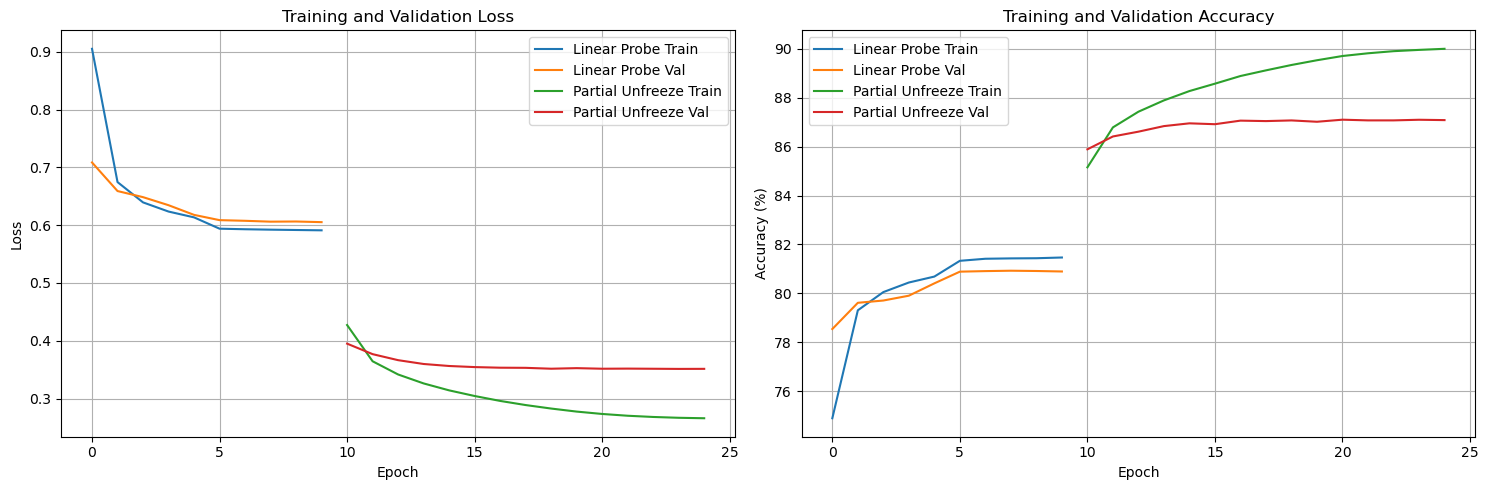

In [17]:
def plot_training_curves(history1, history2, regime1_name, regime2_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history1['train_loss'], label=f'{regime1_name} Train')
    axes[0].plot(history1['val_loss'], label=f'{regime1_name} Val')
    axes[0].plot(range(len(history1['train_loss']), 
                      len(history1['train_loss']) + len(history2['train_loss'])),
                history2['train_loss'], label=f'{regime2_name} Train')
    axes[0].plot(range(len(history1['val_loss']), 
                      len(history1['val_loss']) + len(history2['val_loss'])),
                history2['val_loss'], label=f'{regime2_name} Val')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy plot
    axes[1].plot(history1['train_acc'], label=f'{regime1_name} Train')
    axes[1].plot(history1['val_acc'], label=f'{regime1_name} Val')
    axes[1].plot(range(len(history1['train_acc']), 
                      len(history1['train_acc']) + len(history2['train_acc'])),
                history2['train_acc'], label=f'{regime2_name} Train')
    axes[1].plot(range(len(history1['val_acc']), 
                      len(history1['val_acc']) + len(history2['val_acc'])),
                history2['val_acc'], label=f'{regime2_name} Val')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_curves(history_regime1, history_regime2, 
                    "Linear Probe", "Partial Unfreeze")

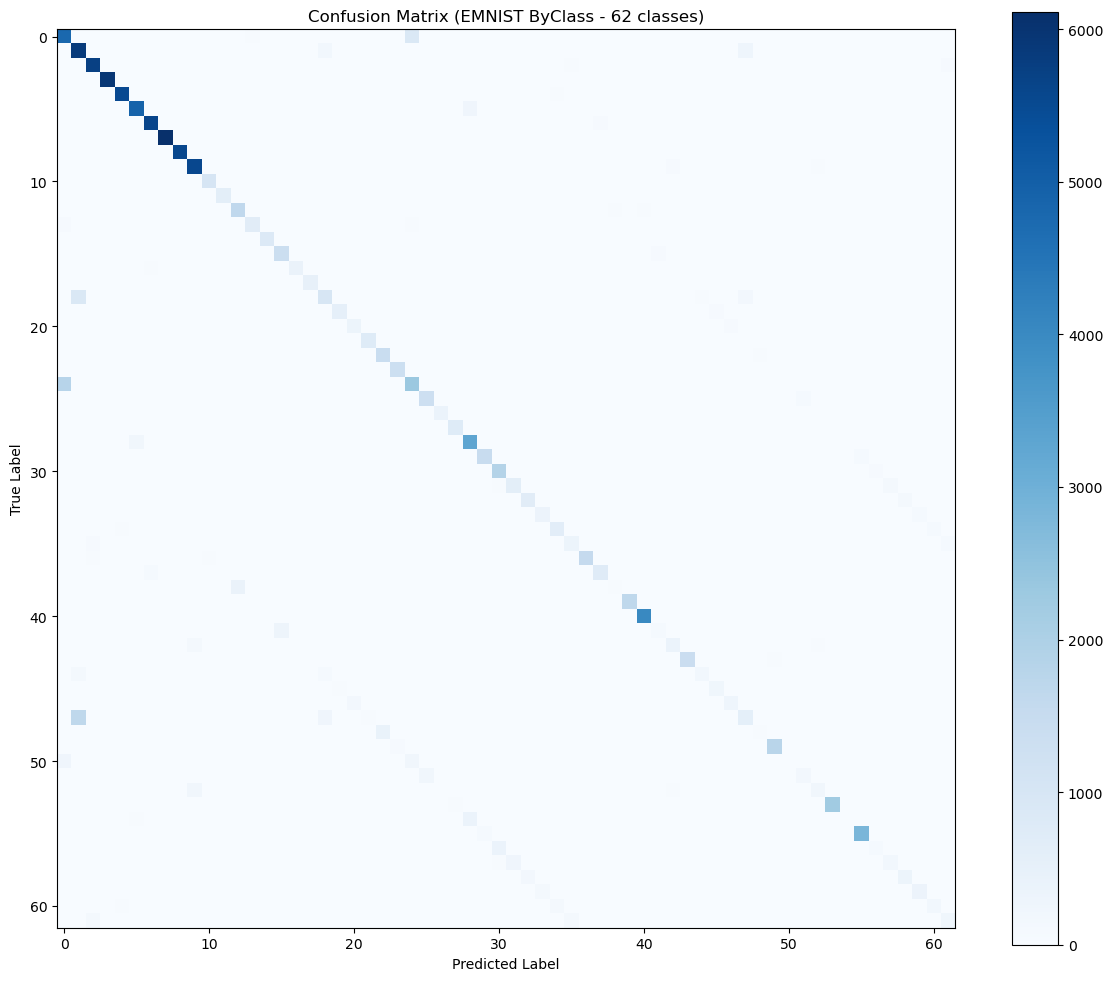

In [18]:
def plot_confusion_matrix(conf_matrix, num_classes=62):
    plt.figure(figsize=(12, 10))
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.title('Confusion Matrix (EMNIST ByClass - 62 classes)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(test_metrics['confusion_matrix'])

In [19]:
print(f"\n{'='*70}")
print("EFFICIENCY ACCOUNTING")
print(f"{'='*70}")

total_train_samples = len(train_dataset)

print(f"\n{'Regime':<20} {'Test Acc':<12} {'Params (M)':<12} {'Epochs×Samples':<15} {'Hardware':<15} {'Time (min)':<12}")
print("-" * 100)

# Regime 1
epochs_regime1 = 10
samples_regime1 = epochs_regime1 * total_train_samples
print(f"{'Linear Probe':<20} {test_metrics['accuracy']*100:>10.2f}% {trainable_params_regime1:>10.2f}M "
      f"{epochs_regime1}×{total_train_samples:<8} {str(device):<15} {time_regime1/60:>10.2f}")

# Regime 2  
epochs_regime2 = 15
samples_regime2 = epochs_regime2 * total_train_samples
total_time = time_regime1 + time_regime2
print(f"{'Partial Unfreeze':<20} {test_metrics['accuracy']*100:>10.2f}% {trainable_params_regime2:>10.2f}M "
      f"{epochs_regime2}×{total_train_samples:<8} {str(device):<15} {time_regime2/60:>10.2f}")

print(f"\nTotal training time: {total_time/60:.2f} minutes")


EFFICIENCY ACCOUNTING

Regime               Test Acc     Params (M)   Epochs×Samples  Hardware        Time (min)  
----------------------------------------------------------------------------------------------------
Linear Probe              87.16%       0.03M 10×628138   cuda                 76.47
Partial Unfreeze          87.16%       8.43M 15×628138   cuda                122.41

Total training time: 198.88 minutes


In [20]:
# Save all metrics to a file for the report
with open('results_summary.txt', 'w') as f:
    f.write("TASK 2: ResNet-18 EMNIST Fine-Tuning Results\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Test Accuracy: {test_metrics['accuracy']*100:.2f}%\n")
    f.write(f"Test Precision (macro): {test_metrics['precision']:.4f}\n")
    f.write(f"Test Recall (macro): {test_metrics['recall']:.4f}\n")
    f.write(f"Test F1-score (macro): {test_metrics['f1']:.4f}\n\n")
    
    f.write("Efficiency Accounting:\n")
    f.write(f"Regime 1 (Linear Probe): {trainable_params_regime1:.2f}M params, "
            f"{time_regime1/60:.2f} min\n")
    f.write(f"Regime 2 (Partial Unfreeze): {trainable_params_regime2:.2f}M params, "
            f"{time_regime2/60:.2f} min\n")
    f.write(f"Total time: {total_time/60:.2f} minutes\n")
    f.write(f"Device: {device}\n")

print("\nResults saved to results_summary.txt")
print("Figures saved: training_curves.png, confusion_matrix.png")


Results saved to results_summary.txt
Figures saved: training_curves.png, confusion_matrix.png
